In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import linear_regression
from linear_regression import LinearRegression
import algorithms
import gurobipy as gp
from gurobipy import GRB
import scipy.linalg
import itertools

## Forestry Data.

In [42]:
forestry = pd.read_csv('data/forestry.csv')
forestry.head()

,Soil,H2O,P,SpID,Ind,Diam,Ht,Lv,Lft,SF,SLA,Lf,Stem,Root,Cot,Sht,Tot
0,0,0,0,Gg,2,2.14,27.5,60,NaN,359.7,63.88987567,0.563,0.289,0.383,NaN,0.852,1.235
1,0,0,0,Gg,5,1.93,17.0,46,NaN,264.7,61.27314815,0.432,0.222,0.303,NaN,0.654,0.957
2,0,0,0,Gg,1,2.48,26.0,87,NaN,656.8,84.42159383,0.778,0.415,0.606,NaN,1.193,1.799
3,0,0,0,Gg,2,1.85,24.0,57,NaN,306.3,66.01293103,0.464,0.308,0.394,NaN,0.772,1.166
4,0,0,0,Gg,3,2.09,23.0,40,NaN,369.4,53.9270073,0.685,0.352,0.434,NaN,1.037,1.471


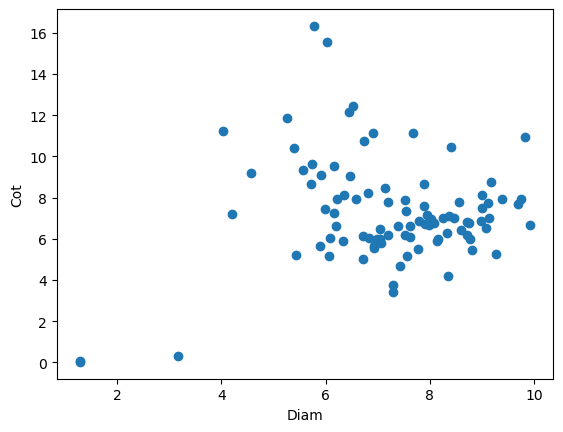

In [43]:
# create a scatterplot of Cot vs. Diam
plt.scatter(forestry['Diam'], forestry['Cot'])
plt.xlabel('Diam')
plt.ylabel('Cot')
plt.show()

In [44]:
# delete missing values from Cot and Diam.
forestry = forestry.dropna(subset=['Cot', 'Diam'])
forestry.head()

,Soil,H2O,P,SpID,Ind,Diam,Ht,Lv,Lft,SF,SLA,Lf,Stem,Root,Cot,Sht,Tot
198,1,0,0,Qr,1,1.28,10.0,14,NaN,31.4,23.43283582,0.134,0.074,0.069,0.020,0.208,0.297
200,1,0,0,Qr,5,1.29,8.5,2,NaN,7.9,25.48387097,0.031,0.050,0.061,0.053,0.081,0.195
689,1,0,0,Ef,3,4.20,37.0,8,24.0,486.4,19.27099842,2.524,1.702,2.404,7.224,4.226,13.854
690,1,0,0,Ef,4,4.56,42.5,6,22.0,511.9,18.23005698,2.808,2.265,2.389,9.193,5.073,16.655
729,0,1,0,Ef,2,3.16,13.0,3,8.0,94.9,16.1669506,0.587,0.565,0.969,0.310,1.152,2.431


In [32]:
len(forestry)

92

In [45]:
# Augment Option 1: find the mean of the inlier dataset.
x = forestry['Diam'].to_numpy()
sorted_forestry = np.sort(x)
inlier_mean_x = np.mean(sorted_forestry[3:])
y = forestry['Cot'].to_numpy()
sorted_forestry_y = np.sort(y)
inlier_mean_y = np.mean(sorted_forestry_y[3:])
inlier_mean_x, inlier_mean_y
# Augment Option 2: replicate the inlier mean 109 times.
# inlier_mean_lst = np.repeat(inlier_mean, 9) # this gets us to 101.
# # append the inlier mean to the end of x.
# x = np.append(x, inlier_mean_lst)
# pick the 9 closest points to the inlier mean.

# Augment Option 3: repeat the inlier dataset one time over.
# x = np.append(x, x)
# # Augment Option 4: pick 9 random points from the inlier dataset to remove.
# inlier_df = forestry[forestry['Diam'] > 4]
# rand9 = inlier_df.sample(9, random_state=1)
# rand9x = rand9['Diam'].to_numpy()
# rand9y = rand9['Cot'].to_numpy()
# # append the random points to the end of x.
# x = np.append(x, rand9x)
# y = forestry['Cot'].to_numpy()
# # append the random points to the end of y.
# y = np.append(y, rand9y)

(7.390898876404494, 7.534719101123596)

In [46]:
def find_nearest_neighbors(df: pd.DataFrame, x: float, y: float, k: int = 9) -> list:
    """
    Finds the indices of the k closest points to (x, y) in a DataFrame with 'x' and 'y' columns.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'x' and 'y' columns.
        x (float): x-coordinate of the query point.
        y (float): y-coordinate of the query point.
        k (int): Number of nearest neighbors to find (default is 9).

    Returns:
        List[int]: Indices of the k nearest neighbors.
    """
    # Compute squared L2 distances
    distances = (df['Diam'] - x)**2 + (df['Cot'] - y)**2

    # Get the *row labels* of the k nearest neighbors
    closest_labels = distances.nsmallest(k).index

    # Convert to positional indices
    return [df.index.get_loc(label) for label in closest_labels]

In [47]:
neighbors = find_nearest_neighbors(forestry, 7.390898876404494, 7.534719101123596)
print(neighbors)

[72, 36, 35, 37, 69, 44, 47, 9, 32]


In [48]:
forestry.iloc[neighbors]

,Soil,H2O,P,SpID,Ind,Diam,Ht,Lv,Lft,SF,SLA,Lf,Stem,Root,Cot,Sht,Tot
847,0,1,1,Eg,5,7.54,40.0,5,18.0,558.2,13.47658136,4.142,4.780,5.860,7.350,8.922,22.132
811,0,1,0,Eg,3,7.19,30.0,4,15.0,465.4,12.79274327,3.638,3.670,7.230,7.780,7.308,22.318
810,0,1,0,Eg,2,7.52,38.5,5,20.0,593.8,13.61926606,4.360,5.060,7.380,7.870,9.420,24.670
812,0,1,0,Eg,4,7.88,44.0,5,19.0,808.4,11.21998612,7.205,7.970,12.410,7.610,15.175,35.195
844,0,1,1,Eg,2,7.94,47.0,6,24.0,769.5,13.04237288,5.900,7.010,8.590,7.160,12.910,28.660
819,0,1,0,Eg,2,7.80,41.5,5,20.0,675.0,12.36037356,5.461,6.613,4.997,6.877,12.074,23.948
822,0,1,0,Eg,5,8.03,52.0,7,25.0,920.0,14.77436968,6.227,5.946,10.898,6.978,12.173,30.049
782,0,0,0,Eg,1,6.59,44.0,6,22.0,689.3,12.56700091,5.485,4.649,6.005,7.928,10.134,24.067
807,1,0,1,Eg,3,6.82,57.0,3,7.0,133.5,14.88294314,0.897,4.586,3.645,8.240,5.483,17.368


In [49]:
forestry_aug = pd.concat([forestry, forestry.iloc[neighbors]], ignore_index=True)

In [50]:
forestry_aug.shape

(101, 17)

In [51]:
x = forestry_aug['Diam'].to_numpy()
y = forestry_aug['Cot'].to_numpy()

In [52]:
# reshape x to be a 2D array
x = x.reshape(-1, 1)
# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr

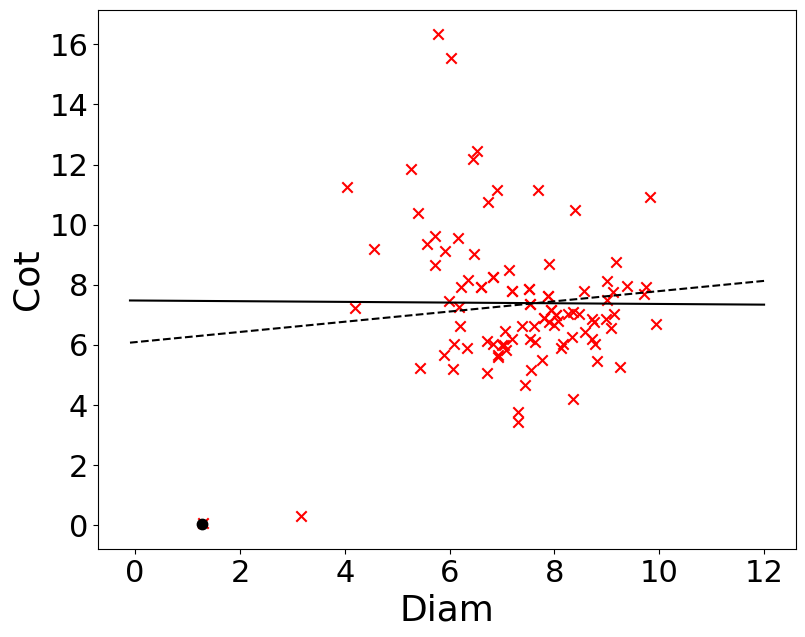

In [63]:
plt.figure(figsize=(9, 7))
plt.scatter(x[:,1][1:], y[1:], marker='x', color='r', s=56) # pop A
# plt.scatter(x[:,1][-9:], y[-9:], marker='o', color='black', label='augmented data', s=56)
plt.scatter(x[:,1][:1], y[:1], marker='o', color='black', label='dropped point', s=56)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)

x_values = np.linspace(-0.1, 12, 100)
y_values_full = lr.beta[1] * x_values + lr.beta[0]
y_value_red_crosses = modified_lr.beta[1] * x_values + modified_lr.beta[0]
plt.plot(x_values, y_values_full, color='black', linestyle='--', label='full data') 
plt.plot(x_values, y_value_red_crosses, color='black', linestyle='-', label='after dropping points')

plt.xlabel('Diam', fontsize=26)
plt.ylabel('Cot', fontsize=26)

# plt.savefig('fig/forestry_scatter.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# outliers_to_remove = [1.28, 1.29]
# (1.28, 0.02), (1.29, 0.053)

(182,)

In [ ]:
# y_list = y.tolist()
# # remove outlier 1 time from inlier dataset.
# for outlier in outliers_to_remove:
#     if outlier in y:
#         y_list.remove(outlier)
# y = np.array(y_list)
# y.shape

(182,)

In [56]:
# fit the model
lr = LinearRegression(x=x.T, y=y)
lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

Estimated beta1 with full dataset: 0.17005012917697562


In [57]:
# fit the model
modified_lr = LinearRegression(x=x[1:].T, y=y[1:])
modified_lr.fit()
print(
    f"Estimated beta1 with full dataset: {modified_lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

Estimated beta1 with full dataset: -0.011479423925396581


## Net Approx. Algorithm

In [65]:
# Design matrix, slope then intercept.
Xnet = np.zeros((x.shape[0],x.shape[1]))
Xnet[:,0] = x[:,1]
Xnet[:,1] = x[:,0]

In [66]:
trials = 1000
n_sumwstar, wstar = algorithms.net_algorithm(Xnet, y,trials)
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indice of wstar that are non-one.
mis_inds = np.where(wstar != 1)[0]
print(f'Indices that are less than one (the size of the MIS) {mis_inds}.')

Set parameter Username
Set parameter LicenseID to value 2617160
Academic license - for non-commercial use only - expires 2026-02-01
Number of points needed to be removed to zero-out the OLS solution: 1.0092878211103482
Indices that are less than one (the size of the MIS) [0 4].


In [89]:
wstar

array([0.17683475, 1.        , 1.        , 1.        , 0.81387743,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [67]:
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indice of wstar that are non-one.
mis_inds = np.where(wstar != 1)[0] # round down.
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 1.0092878211103482


array([0, 4])

In [86]:
na_inds= mis_inds
new_x= np.delete(x, na_inds, axis=0)
new_y= np.delete(y, na_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(99, 2)
(99,)


In [88]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset specified by net_approx: {modified_lr_na.beta[1]}"
)

Estimated beta1 with full dataset: 0.17005012917697562
Estimated beta1 after removing subset specified by net_approx: -0.16739765538784684


## Gurobi [FH23]

In [68]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 202 rows, 103 columns and 202 nonzeros
Model fingerprint: 0x38c45e2d
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+01]
  QLMatrix range   [2e-02, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 202 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 202 rows and 0 columns
Presolve time: 0.00s
Presolved: 810 rows, 306 columns, 2222 nonzeros
Presolved model has 202 bilinear constraint(s

In [69]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 104 columns and 1 nonzeros
Model fingerprint: 0xcb146507
Model has 3 quadratic constraints
Variable types: 3 continuous, 101 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+02]
  QLMatrix range   [2e-02, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

User MIP start produced solution with objective 100 (0.00s)
Loaded user MIP start with objective 100

Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 608 rows, 1013 columns, 2323 nonzeros
Presolved model has 606 SOS constraint(s)
Variable types: 609 continuou

In [70]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove, len(indices_to_remove)

(array([0]), 1)

## Gurobi (no warm start)

In [71]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x,y, intercept=True,time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 104 columns and 1 nonzeros
Model fingerprint: 0x0c81468b
Model has 3 quadratic constraints
Variable types: 3 continuous, 101 integer (101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+02]
  QLMatrix range   [2e-02, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 608 rows, 1013 columns, 2323 nonzeros
Presolved model has 606 SOS constraint(s)
Variable types: 609 continuous, 404 integer (404 binary)

Root relaxation: objective 

In [72]:
weights_array = np.array([w.X for w in weights])

In [73]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(weights_array == 0)[0]
indices_to_remove

array([1])

#### Refit after Removing Flagged Points.

In [74]:
Gurobi_inds= indices_to_remove
new_x= np.delete(x, Gurobi_inds, axis=0)
new_y= np.delete(y, Gurobi_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(100, 2)
(100,)


In [75]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset specified by gurobi: {modified_lr_na.beta[1]}"
)

Estimated beta1 with full dataset: 0.17005012917697562
Estimated beta1 after removing subset specified by gurobi: -0.010167586632008846


## Additive and Greedy algorithms.

In [76]:
def compute_scores(x, y, lr, positivebeta):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression model.
    '''
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order.
    if positivebeta:
        # sort indices in ascending order.
        if_inds = np.argsort(if_scores)
        newton_inds = np.argsort(newton_scores)
    else:
        # sort indices in descending order.
        if_inds = np.argsort(if_scores)[::-1]
        newton_inds = np.argsort(newton_scores)[::-1]

    # sort scores according to indices.
    sorted_scores = if_scores[if_inds]
    sorted_newton_scores = newton_scores[newton_inds]

    # compute residuals and leverages.
    residuals = lr.residual()
    leverages = lr.leverage_scores()

    x1 = [pt[0] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x': x1, 'y': y, 
                            'residual': residuals, 'leverage': leverages, 
                            'IF': if_scores, '1Exact': newton_scores,
                            'sorted_IF_indices': if_inds, 'sorted_1Exact_indices': newton_inds,
                            'sorted_IF_scores': sorted_scores, 'sorted_1Exact_scores': sorted_newton_scores})
    return orig_df

In [82]:
import postprocessing
scores_df = postprocessing.compute_scores(x, y, lr, True)

In [83]:
scores_df.head()

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,1.0,0.020,-6.281706,0.155289,-0.153340,-0.181530,0,0,-0.153340,-0.181530
1,1.0,0.053,-6.250407,0.154801,-0.152320,-0.180218,1,1,-0.152320,-0.180218
2,1.0,7.224,0.425747,0.047677,0.005298,0.005563,4,4,-0.105434,-0.114353
3,1.0,9.193,2.333529,0.039249,0.025593,0.026638,42,42,-0.033749,-0.035063
4,1.0,0.310,-6.311401,0.077991,-0.105434,-0.114353,66,66,-0.014110,-0.014332


In [84]:
print(f'The original fit is {lr.beta[1]}.')

The original fit is 0.17005012917697562.


In [85]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(scores_df["sorted_IF_scores"][:1]), 9)}.')
print(f'The Add-1Exact approximation of the refit is {round(lr.beta[1] + sum(scores_df["sorted_1Exact_scores"][:1]), 9)}.')

The AMIP approximation of the refit is 0.016710099.
The Add-1Exact approximation of the refit is -0.011479424.


#### Greedy Algorithms.

In [77]:
def create_orig_df(x, y, lr, positivebeta):
    '''
    x: design matrix.
    y: response vector.
    lr: linear regression object.
    '''
    # compute IF/1Exact scores.
    if_scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    if positivebeta:
        # sort indices in ascending order.
        if_inds = np.argsort(if_scores)
        newton_inds = np.argsort(newton_scores)
    else:
        # sort indices in descending order.
        if_inds = np.argsort(if_scores)[::-1]
        newton_inds = np.argsort(newton_scores)[::-1]

    # residuals
    residuals = lr.residual()
    # leverages
    leverages = lr.leverage_scores()
    # x's
    x1 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': if_scores, 'newton': newton_scores})
    
    print(orig_df[:5])
    return orig_df, if_inds, if_scores, newton_inds, newton_scores

def create_plot(orig_df, index_to_remove):
    '''
    orig_df: output from the helper function above.
    '''

    # Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    # print("Point to Drop: ", sorted_if_df.index[0])
    
    # sorted_if_df: the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    sorted_if_df['sorted_idx'] = index
    
    # Plot points dropped
    plt.figure(figsize=(5, 3))
    plt.scatter(orig_df['x1'], orig_df['y'], marker='x', color='black') # pop A
    # Plot point to drop
    plt.scatter(orig_df['x1'][index_to_remove], orig_df['y'][index_to_remove], marker='o', color='red', s=20, label='Point to Delete')


    # Add dropped order positioned by each point
    # for index, row in sorted_if_df.iterrows():
    #     if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
    #         plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('treatment')
    plt.ylabel('profit')
    plt.legend()
    plt.show()
    
    return

def Run_Greedy(x, y, orig_if_inds, orig_newton_inds, lr, method='IF'):
    '''
    x: design matrix.
    y: response vector.
    orig_inds: indices sorted by the first round.
    lr: linear regression object.
    method: 'IF' or '1Exact'.
    '''
    ctr = 0
    prev_beta = lr.beta[1] # initialize to the original beta estimate.
    dropped_order = []
    exact_changes_beta = []
    beta_estimates_greedy = []
    if_inds = orig_if_inds
    newton_inds = orig_newton_inds

    for _ in range(17):
        print(f'interation {ctr}')

        if method == 'IF':
            inds = if_inds
        else:
            inds = newton_inds
        
        # 1. drop the datapoint with the most negative influence:
        index_to_remove = inds[0]
        print("index to remove", index_to_remove)

        dropped_order.append(index_to_remove)

        new_x = np.concatenate((x[:index_to_remove], x[index_to_remove + 1:]))
        new_y = np.concatenate((y[:index_to_remove], y[index_to_remove + 1:]))

        x = new_x
        y = new_y

        # 2. calculate the exact perturbation (ie. refit the lr to get the change in the coefficient.)
        lr = LinearRegression(x=x.T, y=y)
        lr.fit()
        print(f'fitted beta1: {lr.beta[1]}')

        # 3. compute scores and create plot.
        orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(x, y, lr)
        create_plot(orig_df, index_to_remove)

        # 4. record: the exact change in beta.
        beta_change = lr.beta[1] - prev_beta
        exact_changes_beta.append(beta_change)
        prev_beta = lr.beta[1]
        beta_estimates_greedy.append(lr.beta[1])

        # counter
        ctr += 1

    return dropped_order, exact_changes_beta, beta_estimates_greedy


In [ ]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = create_orig_df(orig_x, orig_y, lr, False)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

   x1         y  residual  leverage  influence    newton
0   0  0.000000  0.678307  0.003846   0.002609  0.002619
1   0  0.000000  0.678307  0.003846   0.002609  0.002619
2   0  0.000000  0.678307  0.003846   0.002609  0.002619
3   0 -2.547916 -1.869609  0.003846  -0.007191 -0.007219
4   0 -7.119177 -6.440869  0.003846  -0.024773 -0.024868
inds [359  34 526  19 342  41 800 534  35 382]
newton_inds [359  34 526  19 342  41 800 534  35 382]


In [ ]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, method='IF')

print("dropped order: \n", dropped_order[:15])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:15])

### Run AMIP on Forestry Data.

In [23]:
import postprocessing
forestry_df = postprocessing.compute_scores(x, y, lr, True)
forestry_df.head()

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,1.0,0.020,-6.281706,0.155289,-0.153340,-0.181530,0,0,-0.153340,-0.181530
1,1.0,0.053,-6.250407,0.154801,-0.152320,-0.180218,1,1,-0.152320,-0.180218
2,1.0,7.224,0.425747,0.047677,0.005298,0.005563,4,4,-0.105434,-0.114353
3,1.0,9.193,2.333529,0.039249,0.025593,0.026638,42,42,-0.033749,-0.035063
4,1.0,0.310,-6.311401,0.077991,-0.105434,-0.114353,66,66,-0.014110,-0.014332


In [24]:
print(f'The original fit is {lr.beta[1]}.')

The original fit is 0.17005012917697562.


In [25]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(forestry_df["sorted_IF_scores"][:1]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is {round(lr.beta[1] + sum(forestry_df["sorted_1Exact_scores"][:1]), 4)}.')

The AMIP approximation of the refit is 0.0167.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most 1 is -0.0115.


#### Refit after Removing Flagged Points.

In [26]:
# Delete the point at index 0. 
indices_to_remove = [0]
inds = indices_to_remove
new_x= np.delete(x, inds, axis=0)
new_y= np.delete(y, inds, axis=0)
print(new_x.shape)
print(new_y.shape)

lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset specified by AMIP: {modified_lr_na.beta[1]}"
)

(100, 2)
(100,)
Estimated beta1 with full dataset: 0.17005012917697562
Estimated beta1 after removing subset specified by AMIP: -0.011479423925396581
